

# **Autoencoder on the Fashion MNIST dataset** using PyTorch


An autoencoder is an unsupervised machine learning algorithm. In our example here it takes an image as input and then tries to reconstruct that image using less information.

They do this by projecting higher dimensional data to a lower dimension (similar to Principal Component Analysis) by keeping the feautres of most importance. This is called the latent space. 

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1522830223/AutoEncoder_kfqad1.png)

### **An Autoencoder is comprised of these two Networks**

**Encoder**: compresses/downsamples the input image into a lesser number of bits. This lesser number of bits is called the latent-space or bottleneck. 

**Decoder**: tries to reconstruct the input using only the encoding of the input. If the decoder can reconstruct the image accurately from the output of the encoder you have a properly functioning encoder (able to produce good encodings) and decoder system.

**Tutorial Credit:**

https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/

In [1]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

# image transformations
transform = transforms.Compose([transforms.ToTensor(),])

In [3]:
# Load our FashionMNIST dataset
trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform)

testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 22586879.92it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 2387650.10it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




100%|██████████| 4422102/4422102 [00:00<00:00, 35983323.55it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 4697036.54it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
# Create our Data Loaders
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True)

testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

In [5]:
# Firstly make some utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

## **Create our Autoencoder Model**

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1) # this is because the FC layer expects a 1D tensor and the output of this layer is like (32,28*28) and each row of the reshaped tensor corresponds to one flattened image in the batch. img size befor this is like : (32,1,28,28)  - 32 is the batch size
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))

        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)

    return train_loss

def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break


cuda:0
Epoch 1 of 50, Train Loss: 0.078
Epoch 2 of 50, Train Loss: 0.042
Epoch 3 of 50, Train Loss: 0.036
Epoch 4 of 50, Train Loss: 0.031
Epoch 5 of 50, Train Loss: 0.028
Epoch 6 of 50, Train Loss: 0.027
Epoch 7 of 50, Train Loss: 0.027
Epoch 8 of 50, Train Loss: 0.026
Epoch 9 of 50, Train Loss: 0.025
Epoch 10 of 50, Train Loss: 0.025
Epoch 11 of 50, Train Loss: 0.024
Epoch 12 of 50, Train Loss: 0.022
Epoch 13 of 50, Train Loss: 0.022
Epoch 14 of 50, Train Loss: 0.021
Epoch 15 of 50, Train Loss: 0.021
Epoch 16 of 50, Train Loss: 0.020
Epoch 17 of 50, Train Loss: 0.020
Epoch 18 of 50, Train Loss: 0.020
Epoch 19 of 50, Train Loss: 0.020
Epoch 20 of 50, Train Loss: 0.019
Epoch 21 of 50, Train Loss: 0.019
Epoch 22 of 50, Train Loss: 0.019
Epoch 23 of 50, Train Loss: 0.019
Epoch 24 of 50, Train Loss: 0.019
Epoch 25 of 50, Train Loss: 0.019
Epoch 26 of 50, Train Loss: 0.018
Epoch 27 of 50, Train Loss: 0.018
Epoch 28 of 50, Train Loss: 0.018
Epoch 29 of 50, Train Loss: 0.018
Epoch 30 of 50, 

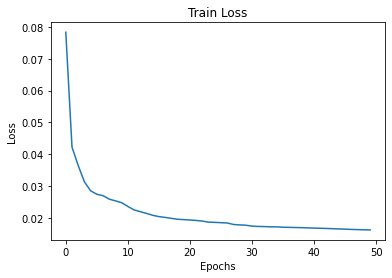

In [11]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)

make_dir()

# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)

# Plot training results
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

# test the network
test_image_reconstruction(net, testloader)

## **Display our Results**

View our reconstructed images.

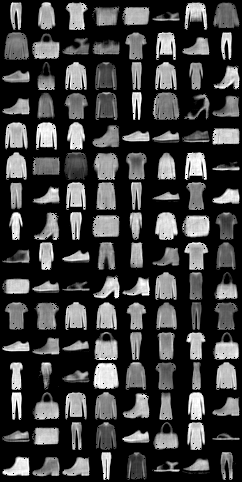

In [12]:
from IPython.display import Image

Image('fashionmnist_reconstruction.png')

### **View the original**

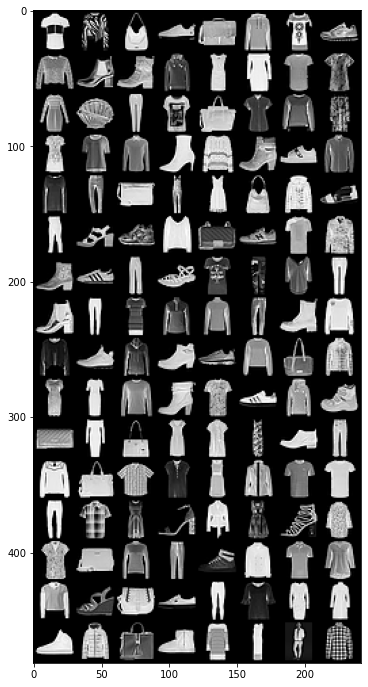

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))